TensorFlow 및 기타 필요한 라이브러리를 가져옵니다.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## 데이터세트 다운로드 및 탐색

In [3]:
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')

228813984/228813984 [==============================] - 3s 0us/step


총 3,670개의 이미지가 있습니다.

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


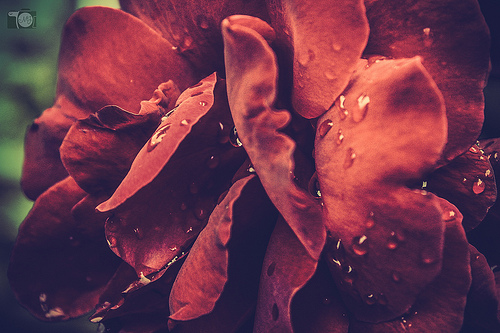

In [5]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

### 데이터세트 만들기

batch 사이즈를 설정하고 몇 가지 매개변수를 정의합니다.

In [38]:
batch_size = 32
img_height = 180
img_width = 180

이미지의 80%를 훈련에 사용하고 20%를 검증에 사용합니다.

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [11]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [12]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## 데이터 시각화

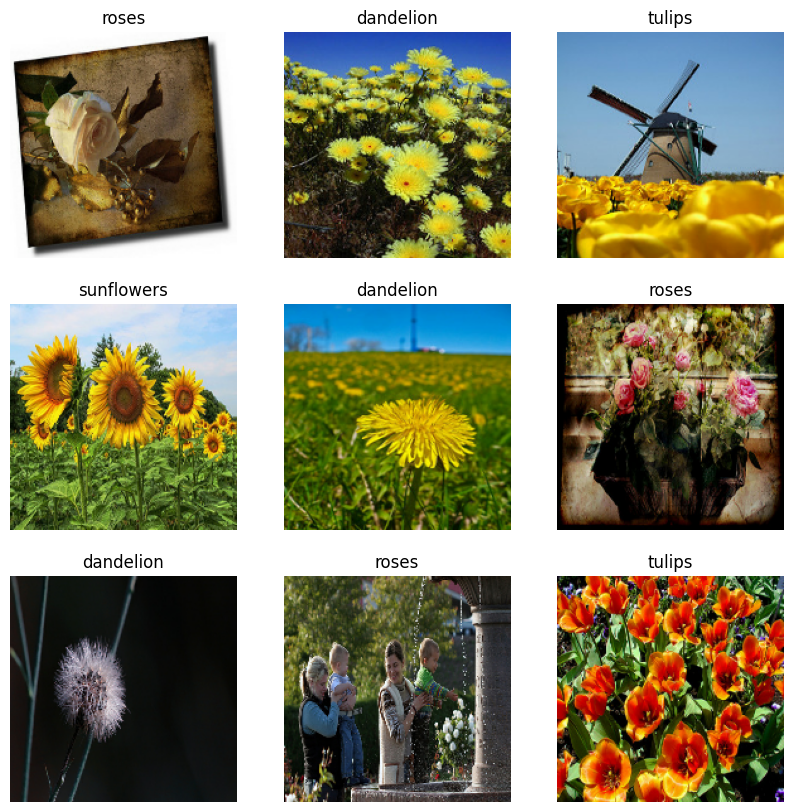

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


## 성능을 높이도록 데이터세트 구성

- `Dataset.cache()`는 첫 epoch 동안 디스크에서 이미지를 로드한 후 이미지를 메모리에 유지. 이렇게 하면 모델을 훈련하는 동안 데이터세트가 병목 상태가 되지 않습니다. 
- `Dataset.prefetch`는 훈련하는 동안 데이터 전처리 및 모델 실행을 중첩시킵니다.

In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## 데이터 표준화

RGB 채널 값은 `[0, 255]` 의 범위를 가지고 있는데, 이 값은 신경망으로 다루기엔 큰 범위라고 생각했습니다.

`tf.keras.layers.Rescaling`을 사용하여 값을 `[0, 1]` 범위로 표준화합니다.

In [16]:
normalization_layer = layers.Rescaling(1./255)

`Dataset.map`을 호출하여 데이터세트에 레이어를 적용합니다.

In [17]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

print(np.min(first_image), np.max(first_image))

0.0 1.0


## 모델 작성

In [18]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### 모델 컴파일

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### 모델 요약

Keras `Model.summary` 메서드를 사용하여 네트워크의 모든 레이어를 봅니다.

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### 모델 훈련

In [21]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 10s 44ms/step - loss: 1.3780 - accuracy: 0.3937 - val_loss: 1.1323 - val_accuracy: 0.5245
Epoch 2/10
92/92 [==============================] - 2s 21ms/step - loss: 1.0569 - accuracy: 0.5729 - val_loss: 1.0355 - val_accuracy: 0.6022
Epoch 3/10
92/92 [==============================] - 2s 23ms/step - loss: 0.9144 - accuracy: 0.6540 - val_loss: 0.9695 - val_accuracy: 0.6499
Epoch 4/10
92/92 [==============================] - 2s 23ms/step - loss: 0.7553 - accuracy: 0.7074 - val_loss: 1.0216 - val_accuracy: 0.5913
Epoch 5/10
92/92 [==============================] - 2s 21ms/step - loss: 0.5964 - accuracy: 0.7708 - val_loss: 0.9275 - val_accuracy: 0.6798
Epoch 6/10
92/92 [==============================] - 2s 22ms/step - loss: 0.4095 - accuracy: 0.8501 - val_loss: 1.0450 - val_accuracy: 0.6512
Epoch 7/10
92/92 [==============================] - 2s 21ms/step - loss: 0.2589 - accuracy: 0.9091 - val_loss: 1.1217 - val_accuracy: 0.6608
Epoch 8/10
9

## 훈련 결과 시각화

훈련 및 검증 세트에 대한 손실과 정확성 플롯을 생성합니다.

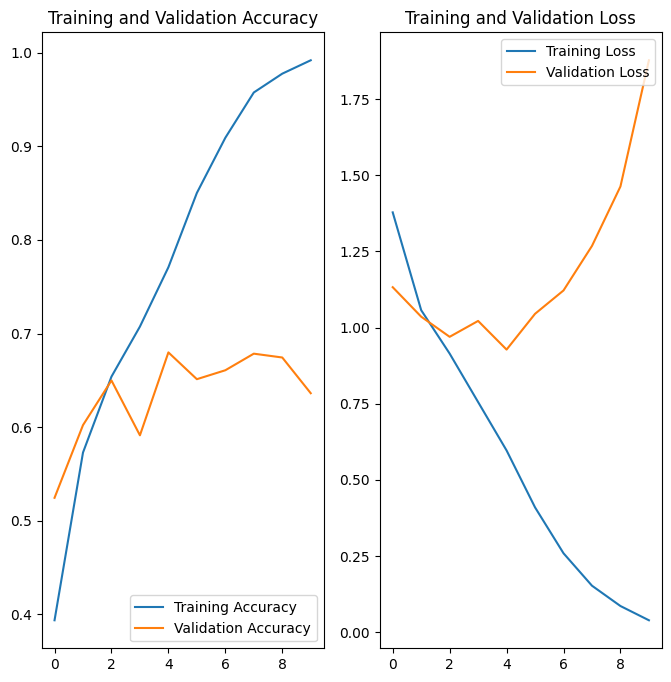

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

플롯은 훈련 정확도와 검증 정확도가 큰 차이로 떨어져 있으며 모델은 검증 세트에서 약 60%의 정확도만을 달성했음을 보여줍니다.

## 과대적합

위의 플롯에서 훈련 정확성은 시간이 지남에 따라 증가하는 반면, 검증 정확성은 훈련 과정에서 약 60%를 벗어나지 못합니다. 또한 훈련 정확성과 검증 정확성 간의 정확성 차이가 상당한데, 이는 과대적합의 징후입니다.

## 데이터 증강

과대적합은 일반적으로 훈련 예제가 적을 때 발생합니다. 데이터 증강은 증강한 다음 믿을 수 있는 이미지를 생성하는 임의 변환을 사용하는 방법으로 기존 예제에서 추가 훈련 데이터를 생성하는 접근법을 취합니다.

Keras 전처리 레이어 `tf.keras.layers.RandomFlip`, `tf.keras.layers.RandomRotation`, `tf.keras.layers.RandomZoom`을 사용하여 데이터 증강을 구현합니다.

In [23]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

동일한 이미지에 데이터 증강을 여러 번 적용하여 몇 가지 증강 예제를 시각화합니다.

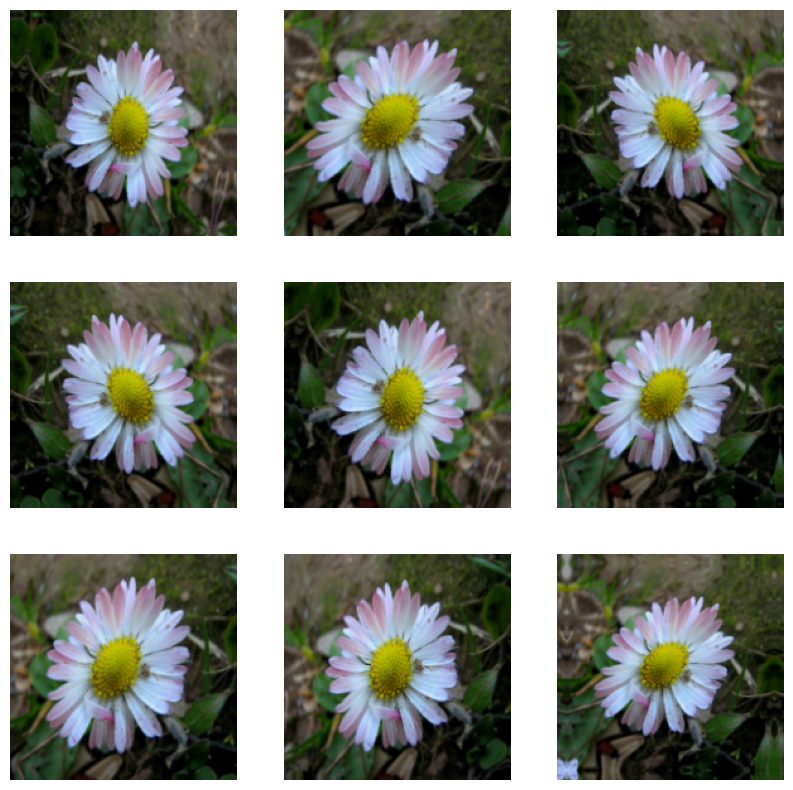

In [24]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## 모델 컴파일 및 훈련하기

In [26]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 90, 90, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                 

In [28]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 6s 31ms/step - loss: 1.3321 - accuracy: 0.4063 - val_loss: 1.0889 - val_accuracy: 0.5654
Epoch 2/15
92/92 [==============================] - 3s 31ms/step - loss: 1.0399 - accuracy: 0.5746 - val_loss: 1.0230 - val_accuracy: 0.5886
Epoch 3/15
92/92 [==============================] - 3s 30ms/step - loss: 0.9334 - accuracy: 0.6294 - val_loss: 0.8729 - val_accuracy: 0.6580
Epoch 4/15
92/92 [==============================] - 3s 29ms/step - loss: 0.8864 - accuracy: 0.6526 - val_loss: 1.0249 - val_accuracy: 0.6063
Epoch 5/15
92/92 [==============================] - 3s 31ms/step - loss: 0.8280 - accuracy: 0.6740 - val_loss: 0.9536 - val_accuracy: 0.6104
Epoch 6/15
92/92 [==============================] - 3s 30ms/step - loss: 0.8073 - accuracy: 0.6832 - val_loss: 0.7801 - val_accuracy: 0.6948
Epoch 7/15
92/92 [==============================] - 3s 32ms/step - loss: 0.7776 - accuracy: 0.7033 - val_loss: 0.7343 - val_accuracy: 0.7084
Epoch 8/15
92

## 훈련 결과 시각화

데이터 증강 적용 후 이전보다 과대적합이 적고 훈련 및 검증 정확도가 더 밀접하게 정렬됩니다.

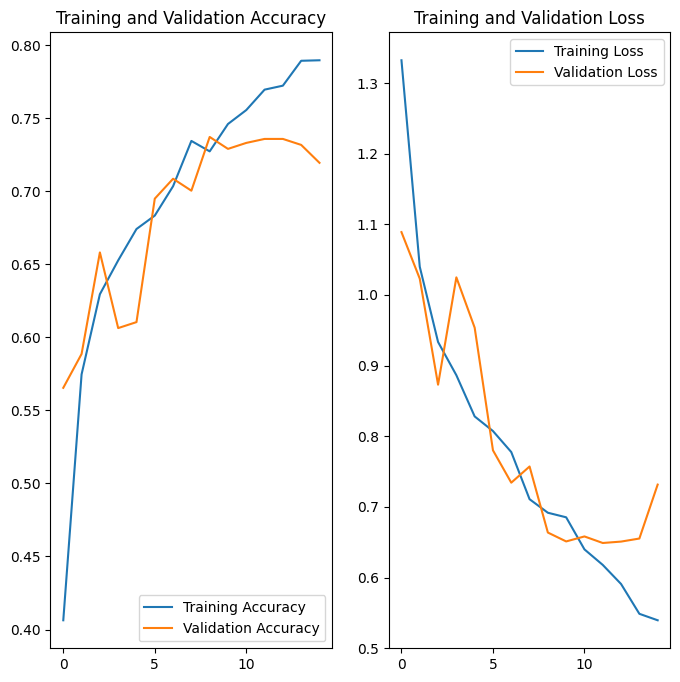

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 새로운 데이터로 예측

모델을 사용하여 훈련 또는 검증 세트에 포함되지 않은 이미지를 분류합니다.

참고: 데이터 증강 및 드롭아웃 레이어는 추론 시 비활성화됩니다.

In [30]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 276ms/step
This image most likely belongs to sunflowers with a 80.23 percent confidence.


## TensorFlow Lite 사용하기

### Keras 순차형 모델을 TensorFlow Lite 모델로 변환

In [31]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

### TensorFlow Lite 모델 실행

In [32]:
TF_MODEL_FILE_PATH = 'model.tflite'

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

변환된 모델의 서명을 인쇄하여 입력(및 출력)의 이름을 얻습니다.


In [33]:
interpreter.get_signature_list()

{'serving_default': {'inputs': ['sequential_1_input'], 'outputs': ['outputs']}}

In [34]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

튜토리얼의 앞부분에서 수행한 것과 마찬가지로 TensorFlow Lite 모델을 사용하여 훈련 또는 검증 세트에 포함되지 않은 이미지를 분류할 수 있습니다.

In [35]:
predictions_lite = classify_lite(sequential_1_input=img_array)['outputs']
score_lite = tf.nn.softmax(predictions_lite)

In [36]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score_lite)], 100 * np.max(score_lite))
)

This image most likely belongs to sunflowers with a 80.23 percent confidence.


Lite 모델에서 생성된 예측은 원래 모델에서 생성된 예측과 거의 동일해야 합니다.

In [37]:
print(np.max(np.abs(predictions - predictions_lite)))

7.1525574e-07


STM32에 대한 이 모델의 C 소스와 헤더 파일을 생성해 보겠습니다. TF Lite에는 TF Lite 모델을 C 소스 및 헤더 파일로 변환하는 Python 메서드가 있습니다. 

In [ ]:
from tensorflow.lite.python.util import convert_bytes_to_c_source

source_text, header_text = convert_bytes_to_c_source(tflite_model,  "image-classify")

with  open('image-classify.h',  'w')  as  file:
    file.write(header_text)

with  open('image-classify.cc',  'w')  as  file:
    file.write(source_text)